### Cookie Cats - A/B Test
###### [Mission] evaluating A/B test and recommend business decision to customers<br>[Data]<br> data: features for games(version, retention...)

### Prepare data

In [24]:
# base
import pandas as pd
import numpy as np
import os

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# analysis
from scipy.stats import shapiro
import scipy.stats as stats

# warning
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action = 'ignore', category = FutureWarning)

# setting
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:4f}'.format

# acquire data
data = pd.read_csv('C:/Users/1004/git/kaggle/Games/cookie_cats.csv')

In [25]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


<h6>
* Note<br>
sum_gamerounds: the number of game played by the player during the first 14 days after install<br>
retention_1: did the player come back and play 1 day after installing?<br>
retention_7: did the player come back and play 7 day after installing?
</h6>

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### Analysis data

In [27]:
print(data.userid.nunique() == data.shape[0])
data.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

True


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.000000,51.872457,195.050858,0.000000,0.000000,1.000000,1.000000,3.000000,16.000000,67.000000,134.000000,221.000000,493.000000,49854.000000


In [28]:
# A/B groups % target summary
data.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.000000,52.456264,256.716423,49854
gate_40,45489,16.000000,51.298776,103.294416,2640


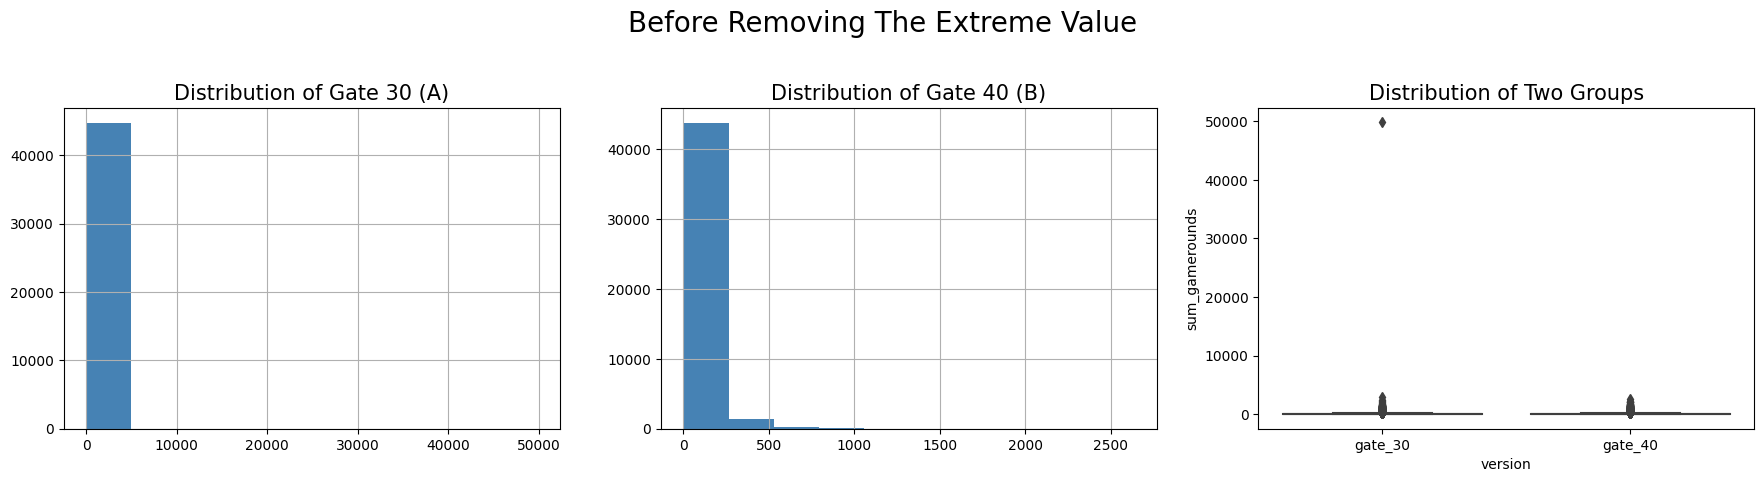

In [29]:
fig, axs = plt.subplots(1, 3, figsize = (18, 5))
data[(data.version == "gate_30")].hist("sum_gamerounds", ax = axs[0], color = "steelblue")
data[(data.version == "gate_40")].hist("sum_gamerounds", ax = axs[1], color = "steelblue")
sns.boxplot(x = data.version, y = data.sum_gamerounds, ax = axs[2])

plt.suptitle("Before Removing The Extreme Value", fontsize = 20)
axs[0].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axs[1].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axs[2].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 2)

Text(0.5, 0.98, 'Before Removing The Extreme Value')

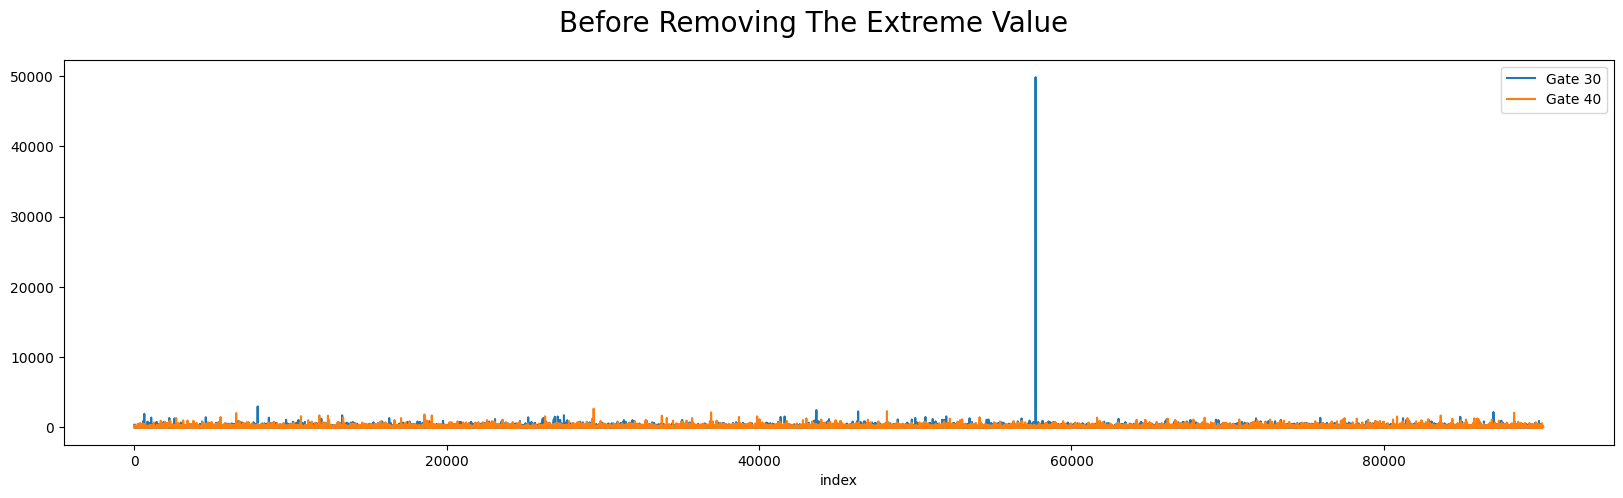

In [30]:
data[data.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20 ,5))
data[data.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")
plt.suptitle("Before Removing The Extreme Value", fontsize = 20)

In [31]:
# outliers
data = data[data.sum_gamerounds < data.sum_gamerounds.max()]
data.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.000000,51.320253,102.682719,0.000000,0.000000,1.000000,1.000000,3.000000,16.000000,67.000000,134.000000,221.000000,493.000000,2961.000000


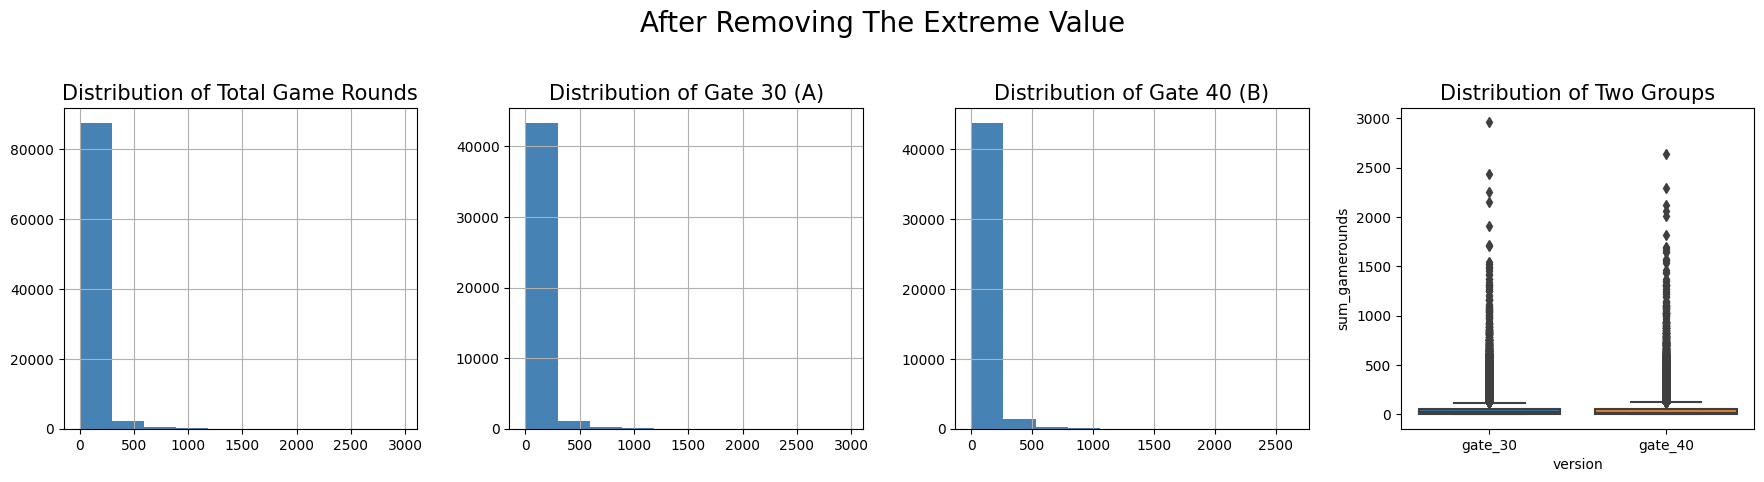

In [32]:
fig, axs = plt.subplots(1, 4, figsize = (18, 5))
data.sum_gamerounds.hist(ax = axs[0], color = "steelblue")
data[(data.version == "gate_30")].hist("sum_gamerounds", ax = axs[1], color = "steelblue")
data[(data.version == "gate_40")].hist("sum_gamerounds", ax = axs[2], color = "steelblue")
sns.boxplot(x = data.version, y = data.sum_gamerounds, ax = axs[3])

plt.suptitle("After Removing The Extreme Value", fontsize = 20)
axs[0].set_title("Distribution of Total Game Rounds", fontsize = 15)
axs[1].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axs[2].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axs[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 2)

Text(0.5, 0.98, 'After Removing The Extreme Value')

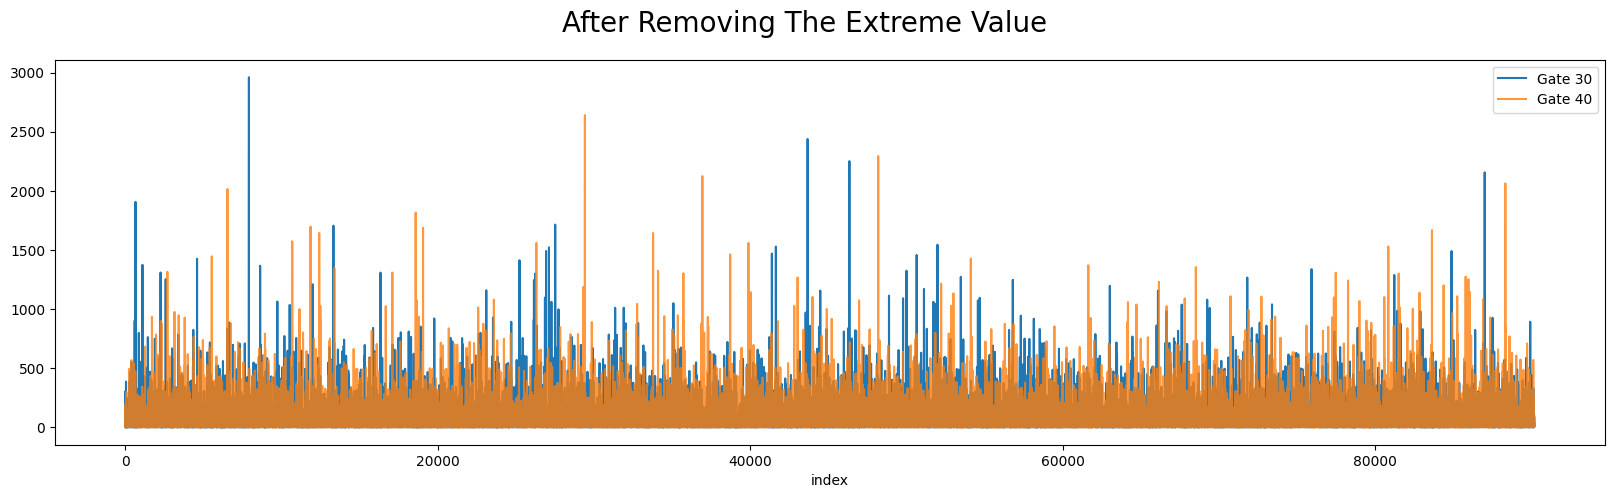

In [33]:
data[(data.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20, 5))
data[(data.version == "gate_40")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("After Removing The Extreme Value", fontsize = 20)

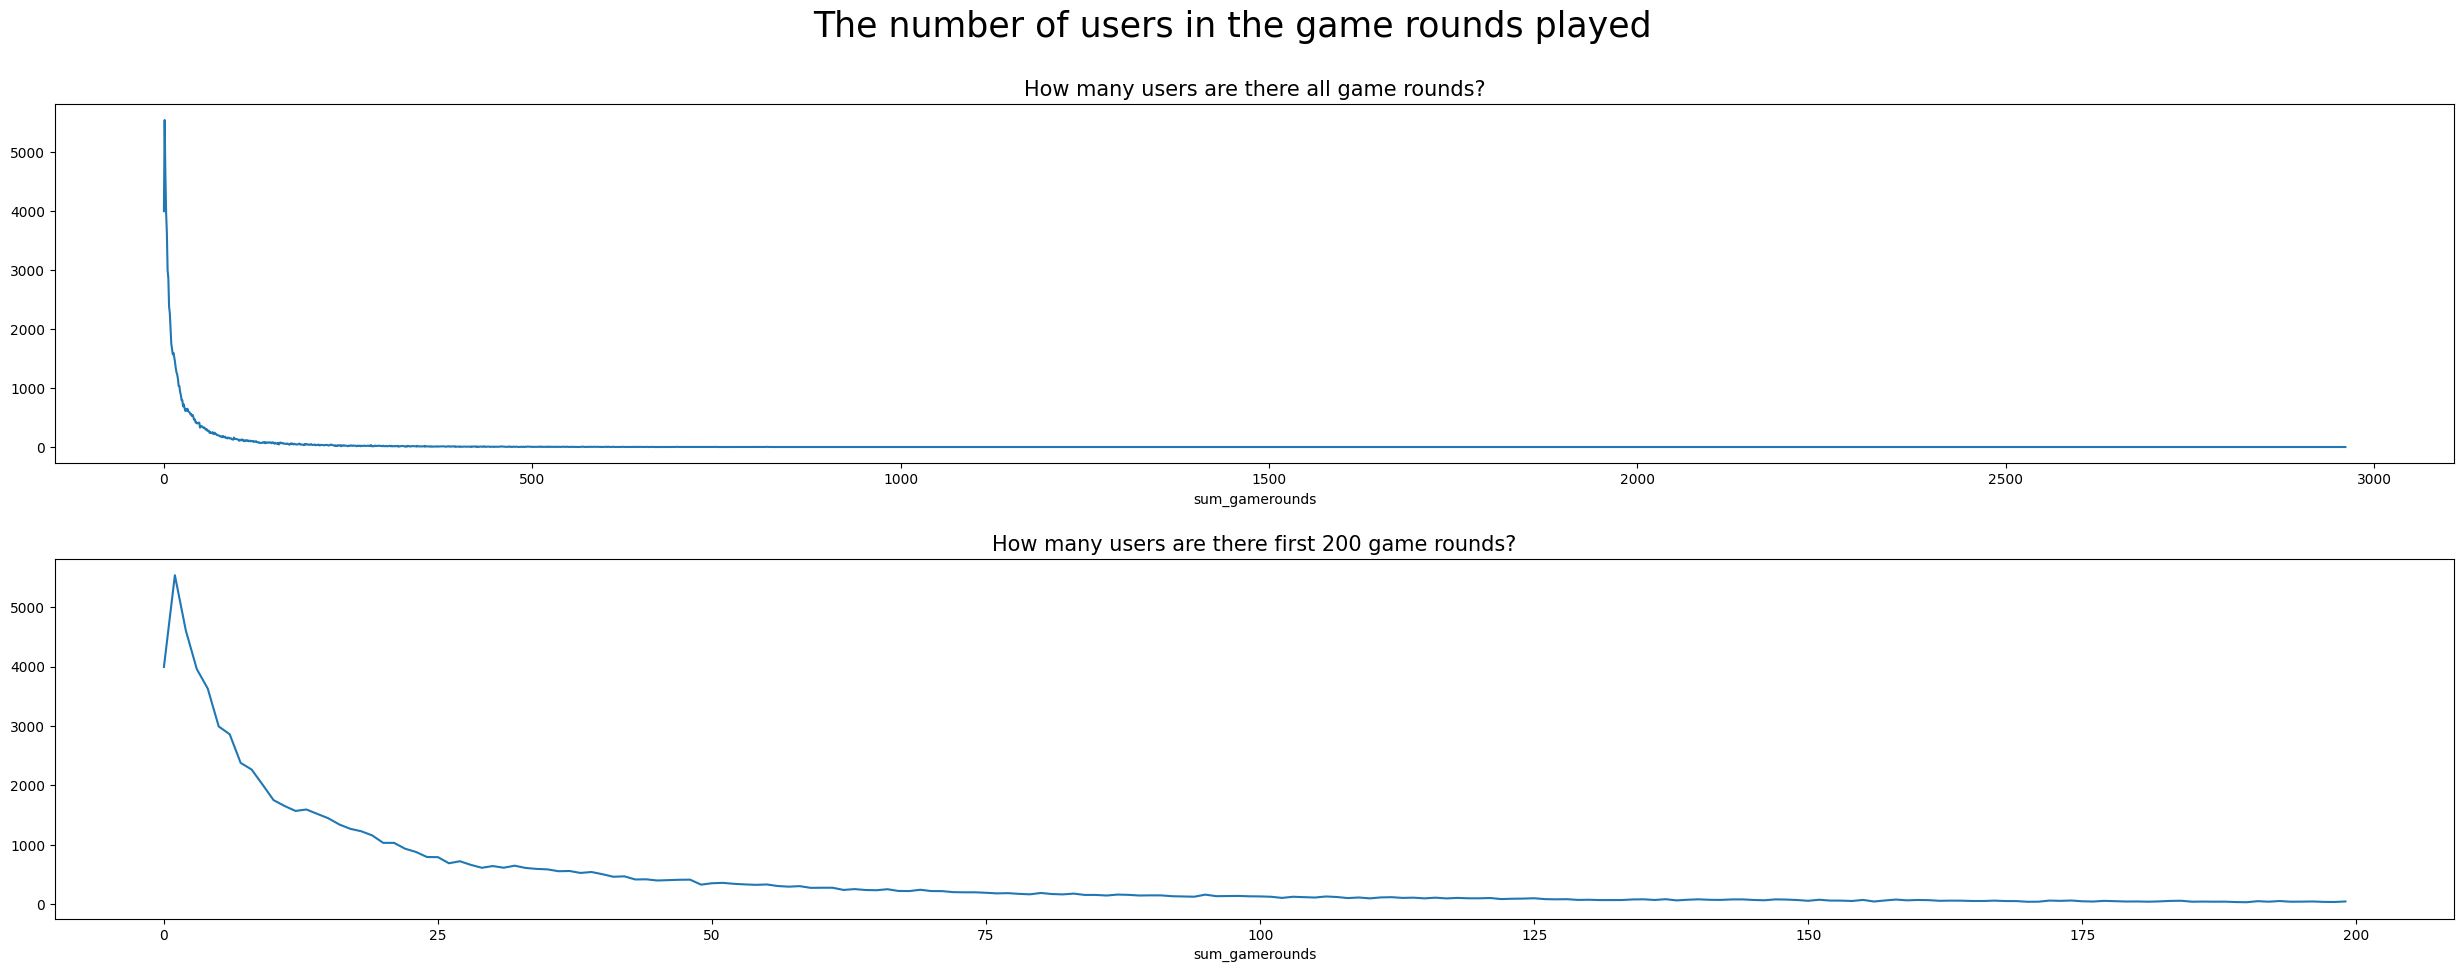

In [34]:
fig, axs = plt.subplots(2, 1, figsize = (25, 10))
data.groupby("sum_gamerounds").userid.count().plot(ax = axs[0])
data.groupby("sum_gamerounds").userid.count()[:200].plot(ax = axs[1])
plt.suptitle("The number of users in the game rounds played", fontsize = 25)
axs[0].set_title("How many users are there all game rounds?", fontsize = 15)
axs[1].set_title("How many users are there first 200 game rounds?", fontsize = 15)
plt.tight_layout(pad = 2)

In [35]:
data.groupby("sum_gamerounds").userid.count().reset_index().head(20)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


In [36]:
data.groupby("sum_gamerounds").userid.count().loc[[30, 40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

In [37]:
data.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.000000,51.342111,102.057598,2961
gate_40,45489,16.000000,51.298776,103.294416,2640


In [38]:
pd.DataFrame({"RET1_COUNT": data["retention_1"].value_counts(),
              "RET7_COUNT": data["retention_7"].value_counts(),
              "RET1_RATIO": data["retention_1"].value_counts() / len(data),
              "RET7_RATIO": data["retention_7"].value_counts() / len(data)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.554786,0.813944
True,40153,16780,0.445214,0.186056


In [39]:
data.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "std", "max"])

count    median        std   max
version retention_1                                  
gate_30 False        24665  6.000000  36.528426  1072
        True         20034 48.000000 135.037697  2961
gate_40 False        25370  6.000000  35.925756  1241
        True         20119 49.000000 137.887256  2640

In [40]:
data["Retention"] = np.where((data.retention_1 == True) & (data.retention_7 == True), 1, 0)
data.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count     median       mean        std   max
version Retention                                              
gate_30 0          38023  12.000000  28.070273  48.017452  1072
        1           6676 127.000000 183.886309 189.626390  2961
gate_40 0          38983  12.000000  28.103353  48.927850  2640
        1           6506 133.000000 190.282355 194.220077  2294

In [41]:
data["NewRetention"] = list(map(lambda x, y: str(x) + "-" + str(y), data.retention_1, data.retention_7))
data.groupby(["version", "NewRetention"]).sum_gamerounds.agg(["count", "median", "std", "mean"]).reset_index()

,version,NewRetention,count,median,std,mean
0,gate_30,False-False,22840,6.000000,21.642643,11.819746
1,gate_30,False-True,1825,43.000000,93.222330,73.169315
2,gate_30,True-False,13358,33.000000,58.125396,49.694490
3,gate_30,True-True,6676,127.000000,189.626390,183.886309
4,gate_40,False-False,23597,6.000000,20.901020,11.913294
5,gate_40,False-True,1773,47.000000,94.478048,75.261139
6,gate_40,True-False,13613,32.000000,60.924587,50.025490
7,gate_40,True-True,6506,133.000000,194.220077,190.282355


### A/B testing

<h6>
* Note(assumptions)<br>
1) check normality<br>
- shapiro(normality)<br>
2) if normal distribution, check homogeneity<br>
- if parametric, levene(homogeneity +, T-test)<br>
- if parametric, levene(homogeneity -, welch test)<br>
- if non-parametric, mann whitney U test
</h6>

In [42]:
data["version"] = np.where(data.version == "gate_30", "A", "B")
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,NewRetention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [51]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    
    
    
# Apply A/B Testing
AB_Test(dataframe=data, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.050892,A/B groups are similar!


In [54]:
def AB_test(dataframe, group, target):
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]

    # assumption: normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: distribution is normal - False
    # H1: distribution is not normal - True

    # parametric test
    if (ntA == False) & (ntB == False): # H0: normal distribution
        # assumption: homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: homogeneity: False
        # H1: homogeneity: True
        if leveneTest == False:
            ttest = stats.ttest_ind(groupA, groupB, equal_var = True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # hetergeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var = False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # non-parametric test
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True

    temp = pd.DataFrame({
        "AB Hypothesis": [ttest < 0.05],
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")

    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity", "AB Hypothesis", "p-value", "Commnet"]]
    else:
        temp = temp[["Test Type", "AB Hypothesis", "p-value", "Comment"]]
    

    print("# A/B Testing hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")

    return temp
 
AB_test(dataframe = data, group = "version", target = "sum_gamerounds")

# A/B Testing hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.050892,A/B groups are similar!


In [55]:
data.groupby("version").retention_1.mean(), data.groupby("version").retention_7.mean()

(version
 A   0.448198
 B   0.442283
 Name: retention_1, dtype: float64,
 version
 A   0.190183
 B   0.182000
 Name: retention_7, dtype: float64)

###### * 아래 링크를 참고 했으며, 개인적인 공부를 위한 코드입니다.<br>참고) https://www.kaggle.com/code/ekrembayar/a-b-testing-step-by-step-hypothesis-testing